# 文本检测——CTPN模型

在本案例中，我们将继续学习深度学习中的OCR（Optical Character Recognition）光学字符识别技术。OCR作为计算机视觉中较早使用深度学习技术的领域，有很多优秀的模型出现，所以通过此案例我们来学习深度学习下的OCR技术。普遍的深度学习下的OCR技术将文字识别过程分为：文本区域检测以及字符识别。本案例中介绍的模型CTPN就是一种文本检测模型，它将图片中的文字部分检测出来。

### 进入ModelArts

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

|项目|建议填写方式|
|-|-|
|名称|自定义环境名称|
|工作环境 | Python3|
| 资源池 | 选择"公共资源池"即可 |
|类型|GPU|
|规格|GPU:1*p100, CPU:8核64GiB|
|存储配置|EVS|
|磁盘规格|5GB|

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后选择TensorFlow 1.13.1开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"ctpn"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！

### 数据和代码下载
运行下面代码，进行数据和代码的下载和解压


In [1]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_ocr_ctpn_text_detection/ctpn.tar"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_ocr_ctpn_text_detection/ctpn.tar"
else:
    print("请更换地区到北京一或北京四")

sess.download_data(bucket_path=bucket_path, path="./ctpn.tar")

Successfully download file modelarts-labs/notebook/DL_ocr_ctpn_text_detection/ctpn.tar from OBS to local ./ctpn.tar


# 解压文件

In [2]:
!tar -xf ctpn.tar

代码中的nms部分以及bbox部分由C语言代码完成，利用Python的扩展模块Cython进行编译。使用C语言进行实现可以提升运行速度，Cython为C语言和Python混合编译的实现模块。所以我们首先编译C语言部分。

In [3]:
import os
pwd = os.getcwd() 
os.chdir('./CTPN/utils/bbox') 
!chmod +x make.sh
!./make.sh
os.chdir(pwd)

running install
running build
running build_ext
building 'bbox' extension
creating build
creating build/temp.linux-x86_64-3.6
gcc -pthread -B /home/ma-user/anaconda3/envs/TensorFlow-1.13.1/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/numpy/core/include -I/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/include/python3.6m -c bbox.c -o build/temp.linux-x86_64-3.6/bbox.o
In file included from /home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822:0,
                 from /home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from bbox.c:580:
/home/ma-user/anaconda3/envs/TensorF

开始案例，首先我们引用相关和库和方法

In [4]:
# coding=utf-8
import shutil
import cv2
import numpy as np
import datetime
import os
import sys
import time
import tensorflow as tf
sys.path.append(os.getcwd())
from tensorflow.contrib import slim

from CTPN import data_provider as data_provider
from CTPN.model import mean_image_subtraction,Bilstm,lstm_fc,loss
from CTPN import vgg
from CTPN import model
from CTPN.utils.rpn_msr.proposal_layer import proposal_layer
from CTPN.utils.text_connector.detectors import TextDetector
from CTPN.utils.image import resize_image

定义变量
- checkpoint_path：checkpoint文件存储路径
- vgg_path：vgg模型checkpoint文件存储路径
- image_path：测试图片存储路径

In [5]:
checkpoint_path = './models/checkpoints/'
vgg_path = "./models/vgg_16.ckpt"
image_path = './data/CTW-200'

CHECKPOINT_PATH = './models/checkpoints'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [6]:
input_image = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_image')
input_bbox = tf.placeholder(tf.float32, shape=[None, 5], name='input_bbox')
input_im_info = tf.placeholder(tf.float32, shape=[None, 3], name='input_im_info')

In [7]:
# 定义并初始化变量global_step 
global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
# 定义变量learning_rate
learning_rate = tf.Variable(1e-5, trainable=False)
# Adam优化器进行优化，学习率为1e-5，非固定值，可以根据学习情况进行设置
opt = tf.train.AdamOptimizer(learning_rate)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
image = mean_image_subtraction(input_image)
# VGG16基础
with slim.arg_scope(vgg.vgg_arg_scope()):
    conv5_3 = vgg.vgg_16(image)
# 加入卷积层
rpn_conv = slim.conv2d(conv5_3, 512, 3)
# 加入双向LSTM
lstm_output = Bilstm(rpn_conv, 512, 128, 512, scope_name='BiLSTM')
# 加入全连接层
# 预测bounding box
bbox_pred = lstm_fc(lstm_output, 512, 10 * 4, scope_name="bbox_pred")
# 预测文字或者非文字类别的分数
cls_pred = lstm_fc(lstm_output, 512, 10 * 2, scope_name="cls_pred")

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


对预测结果利用softmax函数进行归一化计算

In [9]:
cls_pred_shape = tf.shape(cls_pred)
cls_pred_reshape = tf.reshape(cls_pred, [cls_pred_shape[0], cls_pred_shape[1], -1, 2])
cls_pred_reshape_shape = tf.shape(cls_pred_reshape)
cls_prob = tf.reshape(tf.nn.softmax(tf.reshape(cls_pred_reshape, [-1, cls_pred_reshape_shape[3]])),
                      [-1, cls_pred_reshape_shape[1], cls_pred_reshape_shape[2], cls_pred_reshape_shape[3]],
                      name="cls_prob")

定义损失函数

In [10]:
total_loss, model_loss, rpn_cross_entropy, rpn_loss_box = loss(bbox_pred, cls_pred, input_bbox, input_im_info)
batch_norm_updates_op = tf.group(*tf.get_collection(tf.GraphKeys.UPDATE_OPS, '0'))
grads = opt.compute_gradients(total_loss)
summary_op = tf.summary.merge_all()
apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
variables_averages_op = variable_averages.apply(tf.trainable_variables())
with tf.control_dependencies([variables_averages_op, apply_gradient_op, batch_norm_updates_op]):
    train_op = tf.no_op(name='train_op')

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


加载预训练VGG模型参数

In [11]:
init = tf.global_variables_initializer()
variable_restore_op = slim.assign_from_checkpoint_fn(vgg_path,
                                                     slim.get_trainable_variables(),
                                                     ignore_missing_vars=True)
config = tf.ConfigProto(allow_soft_placement=True)

训练模型

In [12]:
with tf.Session(config=config) as sess:
    #加载预训练模型的checkpoint数据
    ckpt = tf.train.latest_checkpoint(checkpoint_path)
    #从50000步开始训练
    restore_step = 50000
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=100)
    saver.restore(sess, ckpt)
    #读取训练数据
    data_generator = data_provider.get_batch(num_workers=4,vis=False,image_path = image_path)
    #开始训练 50000-51000步
    for step in range(restore_step, 50030):
        data = next(data_generator)
        ml, tl, _, summary_str = sess.run([model_loss, total_loss, train_op, summary_op],
                                          feed_dict={input_image: data[0],
                                                     input_bbox: data[1],
                                                     input_im_info: data[2]})
        #设置学习率衰减规则，以30000步为单位衰减
        if step != 0 and step % 30000 == 0:
            sess.run(tf.assign(learning_rate, learning_rate.eval() * 0.1))
        #设置checkpoint存储规则，每2000步存储一次
        if (step + 1) % 2000 == 0:
            filename = ('ctpn_{:d}'.format(step + 1) + '.ckpt')
            filename = os.path.join(checkpoint_path, filename)
            saver.save(sess, filename)
            print('Write model to: {:s}'.format(filename))
        #每训练10步打印一次步数信息
        if step%10 == 0:
            print('train step'+str(step))

Instructions for updating:
Use standard file APIs to check for files with this prefix.


Find 200 images
Find 200 images
Find 200 images
Find 200 images
train step50000
train step50010
train step50020


加载预训练模型

In [13]:
tf.reset_default_graph()
# 定义模型输入信息占位符
input_image = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_image')
input_im_info = tf.placeholder(tf.float32, shape=[None, 3], name='input_im_info')
init_op = tf.initialize_all_variables()
# 定义模型训练步骤数
global_step = tf.variable_scope('global_step', [], initializer=tf.constant_initializer(0))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [14]:
# 加载预训练模型
bbox_pred, cls_pred, cls_prob = model.model(input_image)
variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
# 将变量存储到saver中
saver = tf.train.Saver(variable_averages.variables_to_restore())

预测图片中文字区域位置。加载模型权重文件，将大小调整好的测试图片传入模型，获取预测值。
将测试图片放入路径`img_path`中

In [15]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    # 加载预训练模型权重信息
    ckpt_state = tf.train.get_checkpoint_state(CHECKPOINT_PATH)
    model_path = os.path.join(CHECKPOINT_PATH, os.path.basename(ckpt_state.model_checkpoint_path))
    saver.restore(sess, model_path)
    #加载测试图片
    img_path = './img_6.jpg'
    #对图片进行形状调整
    im = cv2.imread(img_path)[:, :, ::-1]
    img, (rh, rw) = resize_image(im)
    h, w, c = img.shape
    im_info = np.array([h, w, c]).reshape([1, 3])
    #将图片信息传入模型得出预测结果，分别为文字区域坐标以及其得分
    bbox_pred_val, cls_prob_val = sess.run([bbox_pred, cls_prob],feed_dict={input_image: [img],input_im_info: im_info})

In [16]:
textsegs_total, _ = proposal_layer(cls_prob_val, bbox_pred_val, im_info)

此时文本框有对应的预测坐标以及分数，下图将分数大于0.7的预测框绘制出来，可以看到文本框几乎覆盖了文本区域。

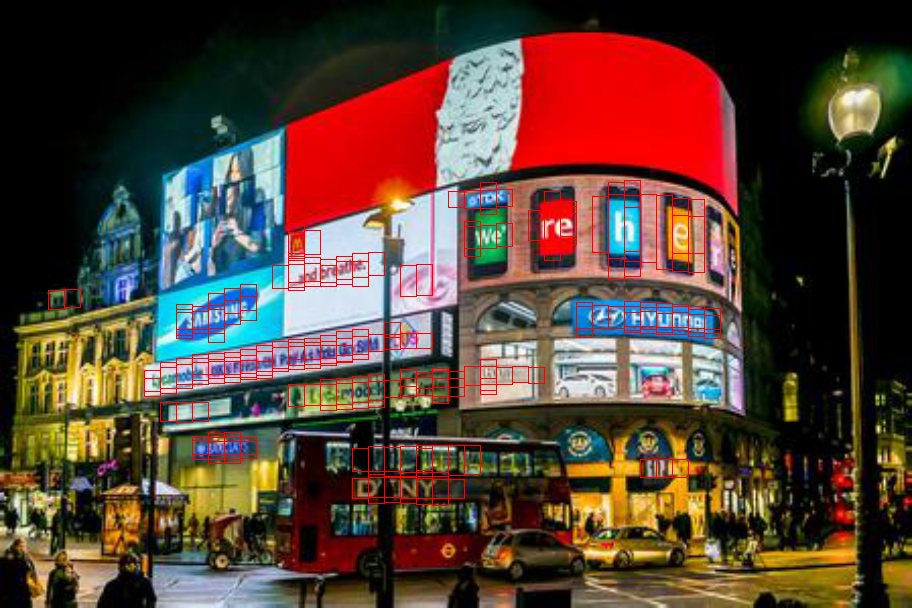

In [17]:
from PIL import Image
img = Image.open(img_path)
img, _  = resize_image(np.array(img))
img = np.array(img)
import cv2 
for i in textsegs_total:
    if i[0] >= 0.7:
        cv2.rectangle(img,(i[1],i[2]),(i[3],i[4]),(255,0,0),1)
img = Image.fromarray(img)
img

对文本位置进行优化，对之前定位出的小矩形框进行合并，向合并后的文本框绘制在图片中。文本框合并时，选取了分数大于0.7的预测框进行合并。

In [18]:
# 重新打开图片准备绘制
from PIL import Image
img = Image.open(img_path)
img, _  = resize_image(np.array(img))
img = np.array(img)
# 进行文本框合并
scores = textsegs_total[:, 0]
textsegs = textsegs_total[:, 1:5]
textdetector = TextDetector(DETECT_MODE='H')
boxes = textdetector.detect(textsegs, scores[:, np.newaxis], img.shape[:2])
boxes = np.array(boxes, dtype=np.int)

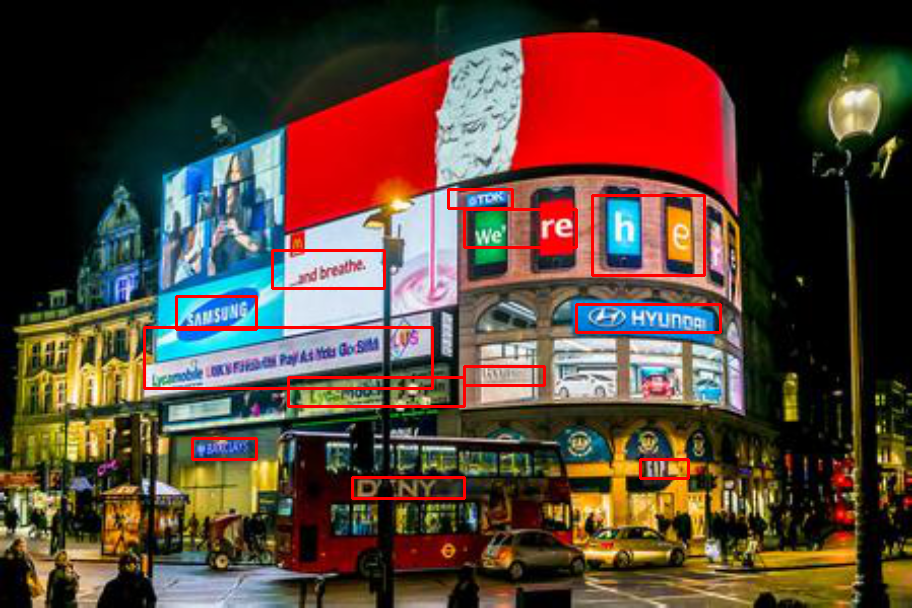

In [19]:
# 绘制文字区域
import cv2
for i, box in enumerate(boxes):
    cv2.polylines(img, [box[:8].astype(np.int32).reshape((-1, 1, 2))], True, color=(255, 0, 0), thickness=2)
img = Image.fromarray(img)
img